In [1]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import sys
sys.path.append('/dfs/scratch0/vschen/metal')

In [3]:
import warnings
warnings.filterwarnings('ignore')

## Generate Data

target sp: 0.1, found sp: 0.10053333333333334, found r: 1.7500000000000009


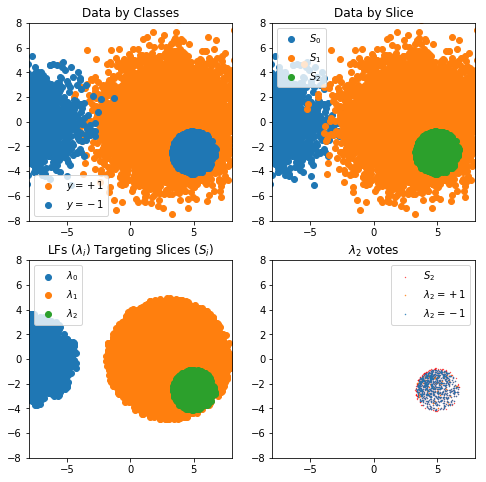

{'N': 10000,
 'mus': [array([-8,  0]), array([3, 0])],
 'labels': [-1, 1],
 'props': [0.25, 0.75],
 'variances': [3, 5],
 'head_config': {'h': 5, 'k': -2.5, 'r': 1.8, 'slice_label': -1},
 'accs': array([0.9, 0.9, 0.9]),
 'covs': [('recall', 0.9), ('recall', 0.9), ('recall', 0.9)]}

In [184]:
from simulate import data_config as config
from synthetics_utils import generate_synthetic_data
from visualization_utils import visualize_data, display_scores, plot_slice_scores
X, Y, C, L = generate_synthetic_data(config, 'sp', 0.1, verbose=True)

# L[L[:, 2] != 0, 2] = 0 # remove LF2 to show data underneath
visualize_data(X, Y, C, L)
config

## Vary Slice Porportion 
_Ratio fo Green to Orange in Top Right figure_

In [191]:
from simulate import simulate, data_config, experiment_config, model_configs
experiment_config['use_weak_labels_from_gen_model'] = True
experiment_config['x_var'] = 'sp'
experiment_config['num_trials'] = 5
experiment_config['x_range'] = [0.05, 0.1, 0.2, 0.25, 0.3, 0.35, 0.4]
experiment_config['verbose'] = False
sp_scores = \
    simulate(data_config, generate_synthetic_data, experiment_config, model_configs)
display_scores(sp_scores, experiment_config['x_var'], experiment_config['x_range'])

Simulating: sp=0.1



Simulating: sp=0.2



Simulating: sp=0.3


TypeError: display_scores() missing 2 required positional arguments: 'x_var' and 'x_range'

,EndModel,UniformModel,ManualModel,AttentionModel
sp: 0.1,,,,
S0,0.994521,0.994718,0.992806,0.996306
S1,0.951982,0.973633,0.984263,0.966439
S2,0.001274,0.164067,0.296110,0.184091
overall,0.884400,0.912000,0.928800,0.909600


,EndModel,UniformModel,ManualModel,AttentionModel
sp: 0.2,,,,
S0,0.966011,0.995012,0.989486,0.996844
S1,0.979828,0.976357,0.974609,0.971823
S2,0.000000,0.248716,0.383195,0.276162
overall,0.820500,0.865800,0.884300,0.867700


,EndModel,UniformModel,ManualModel,AttentionModel
sp: 0.3,,,,
S0,0.995189,0.995364,0.993580,0.993439
S1,0.968238,0.974959,0.977389,0.957564
S2,0.001802,0.412086,0.305586,0.552317
overall,0.751500,0.849700,0.827900,0.875200


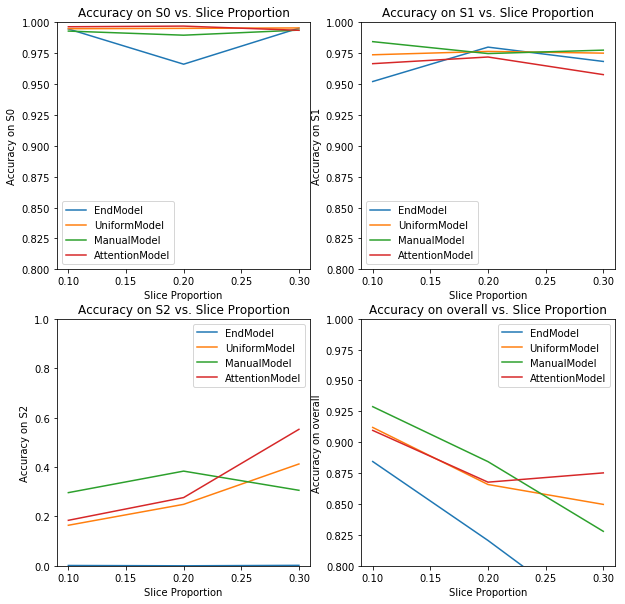

In [192]:
plot_slice_scores(sp_scores, xlabel="Slice Proportion")

## Vary Head LF Accuracy
_blue to orange dots in bottom right figure_

In [190]:
%%time

from simulate import simulate, experiment_config, model_configs
# experiment_config['use_weak_labels_from_gen_model'] = True
experiment_config['x_var'] = 'acc'
experiment_config['num_trials'] = 5
experiment_config['x_range'] = [0.6, 0.7, 0.8, 0.9]
lf_acc_scores = \
    simulate(data_config, generate_synthetic_data, experiment_config, model_configs)

display_scores(lf_acc_scores, experiment_config['x_var'], experiment_config['x_range'])

Simulating: acc=0.6



Simulating: acc=0.7



Simulating: acc=0.8



Simulating: acc=0.9


,EndModel,UniformModel,ManualModel,AttentionModel
acc: 0.6,,,,
S0,0.986569,0.987406,0.992410,0.997618
S1,0.973032,0.982175,0.975581,0.956906
S2,0.000000,0.000000,0.000000,0.000000
overall,0.892700,0.899300,0.894700,0.884700


,EndModel,UniformModel,ManualModel,AttentionModel
acc: 0.7,,,,
S0,0.994268,0.995749,0.995117,0.999161
S1,0.984111,0.977095,0.970742,0.969212
S2,0.000000,0.000000,0.000000,0.000000
overall,0.907800,0.904000,0.899300,0.899200


,EndModel,UniformModel,ManualModel,AttentionModel
acc: 0.8,,,,
S0,0.997904,0.993711,0.997904,0.997904
S1,0.975628,0.961595,0.963072,0.986706
S2,0.000000,0.000000,0.000000,0.000000
overall,0.898500,0.888000,0.890000,0.906000


,EndModel,UniformModel,ManualModel,AttentionModel
acc: 0.9,,,,
S0,0.991801,0.993594,0.987301,0.983423
S1,0.960481,0.969398,0.987023,0.973027
S2,0.000000,0.021617,0.023596,0.038435
overall,0.882400,0.890500,0.902000,0.892400


CPU times: user 9h 27min 51s, sys: 4min 31s, total: 9h 32min 22s
Wall time: 27min 12s


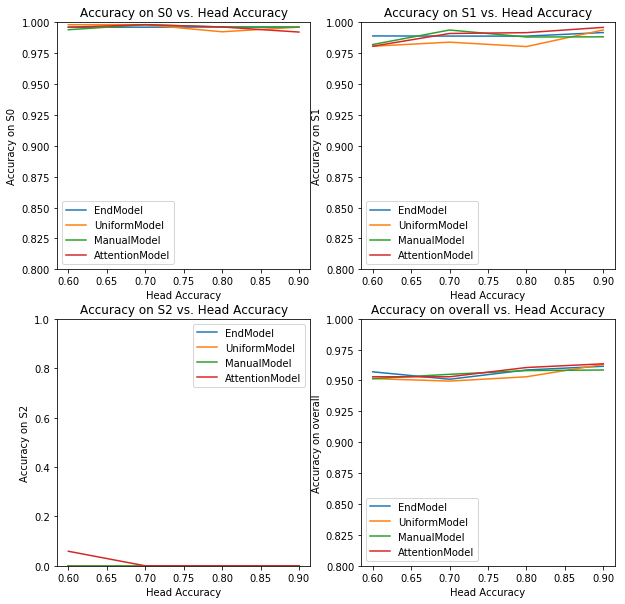

In [141]:
plot_slice_scores(lf_acc_scores, xlabel="Head Accuracy")

## Vary Head LF Precision
_num of blue dots in red slice over num blue bots right_

In [193]:
%%time

from simulate import simulate, experiment_config, model_configs

data_config['head_config']['r'] = 2
experiment_config['use_weak_labels_from_gen_model'] = True
experiment_config['x_var'] = 'cov.precision'
experiment_config['num_trials'] = 5
experiment_config['x_range'] = [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
lf_prec_scores = \
    simulate(data_config, generate_synthetic_data, experiment_config, model_configs)

display_scores(lf_prec_scores, experiment_config['x_var'], experiment_config['x_range'])

Simulating: cov.precision=0.7



Simulating: cov.precision=0.75



Simulating: cov.precision=0.8



Simulating: cov.precision=0.85



Simulating: cov.precision=0.9



Simulating: cov.precision=0.95


,EndModel,UniformModel,ManualModel,AttentionModel
cov.precision: 0.7,,,,
S0,0.994961,0.992201,0.988187,0.996039
S1,0.965643,0.975448,0.979785,0.963877
S2,0.000000,0.054339,0.075174,0.008290
overall,0.865600,0.877300,0.882200,0.865500


,EndModel,UniformModel,ManualModel,AttentionModel
cov.precision: 0.75,,,,
S0,0.991968,0.995438,0.987330,0.992351
S1,0.974481,0.971614,0.980951,0.976651
S2,0.000000,0.011321,0.011650,0.043631
overall,0.874900,0.875600,0.878800,0.881000


,EndModel,UniformModel,ManualModel,AttentionModel
cov.precision: 0.8,,,,
S0,0.999557,0.994032,0.994108,0.990737
S1,0.961503,0.972922,0.979343,0.963462
S2,0.000000,0.041684,0.001810,0.037133
overall,0.864000,0.874100,0.874000,0.866900


,EndModel,UniformModel,ManualModel,AttentionModel
cov.precision: 0.85,,,,
S0,0.999175,0.997633,0.990420,0.992958
S1,0.954929,0.971607,0.981965,0.969152
S2,0.001681,0.027805,0.015596,0.096426
overall,0.864900,0.878100,0.881400,0.882400


,EndModel,UniformModel,ManualModel,AttentionModel
cov.precision: 0.9,,,,
S0,1.000000,0.997495,0.989147,0.995825
S1,0.977456,0.975710,0.986996,0.959162
S2,0.000000,0.081268,0.000000,0.058168
overall,0.880000,0.887700,0.883100,0.873100


,EndModel,UniformModel,ManualModel,AttentionModel
cov.precision: 0.95,,,,
S0,1.000000,0.993711,0.991614,1.000000
S1,0.990015,0.981567,0.985407,0.981567
S2,0.000000,0.000000,0.085973,0.009050
overall,0.883000,0.876000,0.887500,0.878500


CPU times: user 14h 17min 56s, sys: 6min 51s, total: 14h 24min 48s
Wall time: 41min 20s


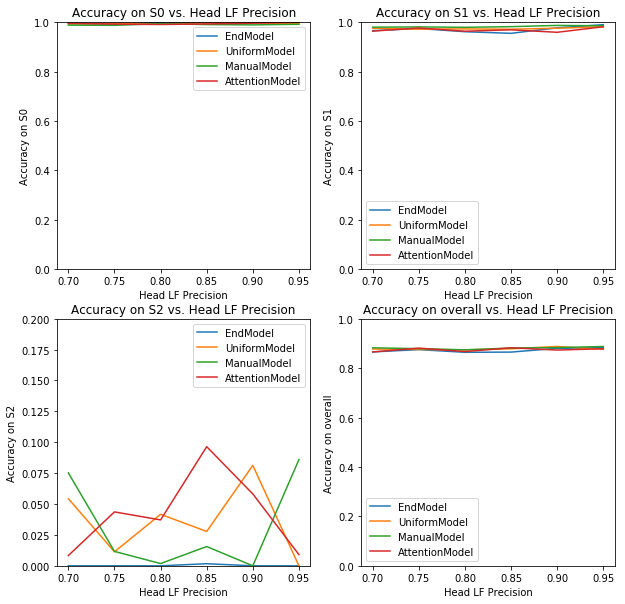

In [203]:
plot_slice_scores(lf_prec_scores, xlabel="Head LF Precision", 
                  custom_ylims={"S2":[0, 0.2]})

## Vary Head LF Recall
_num blue dots in red slice over num red dots in bottom right_

In [204]:
%%time

from simulate import simulate, data_config, experiment_config, model_configs

data_config['head_config']['r'] = 2
experiment_config['use_weak_labels_from_gen_model'] = True
experiment_config['x_var'] = 'cov.recall'
experiment_config['num_trials'] = 5
experiment_config['x_range'] = [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

lf_rec_scores = simulate(data_config, generate_synthetic_data, experiment_config, model_configs)
display_scores(lf_rec_scores, experiment_config['x_var'], experiment_config['x_range'])

Simulating: cov.recall=0.6


Simulating: cov.recall=0.7


Simulating: cov.recall=0.8


Simulating: cov.recall=0.9


,EndModel,UniformModel,ManualModel,AttentionModel
cov.recall: 0.6,,,,
S0,0.980265,0.992924,0.993118,0.989825
S1,0.964982,0.976338,0.980663,0.970076
S2,0.000948,0.091970,0.102471,0.086404
overall,0.862700,0.882900,0.887400,0.877800


,EndModel,UniformModel,ManualModel,AttentionModel
cov.recall: 0.7,,,,
S0,0.988781,0.995164,0.988890,0.994369
S1,0.966621,0.971480,0.983839,0.979306
S2,0.005076,0.234308,0.109880,0.099567
overall,0.870800,0.900000,0.891800,0.890200


,EndModel,UniformModel,ManualModel,AttentionModel
cov.recall: 0.8,,,,
S0,0.997479,0.987276,0.990242,0.990392
S1,0.952858,0.972224,0.972364,0.967541
S2,0.002804,0.157746,0.110016,0.365704
overall,0.863700,0.890400,0.886400,0.909500


,EndModel,UniformModel,ManualModel,AttentionModel
cov.recall: 0.9,,,,
S0,0.999216,0.997217,0.992857,0.998812
S1,0.957802,0.973376,0.975894,0.967721
S2,0.000000,0.249015,0.422014,0.298357
overall,0.869600,0.904400,0.924000,0.906500


CPU times: user 9h 27min 40s, sys: 4min 37s, total: 9h 32min 17s
Wall time: 27min 23s


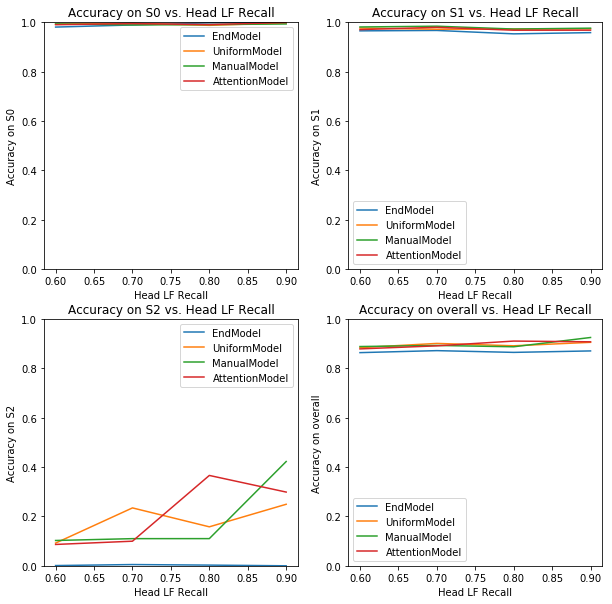

In [206]:
plot_slice_scores(lf_rec_scores, xlabel="Head LF Recall")